# Document Embeddings on Product Reviews

This notebook contains the process of training the document embeddings (doc2vec) using the product reviews and metadata from amazon. Each review is for a signle product, each product might belong to one or more categories.

Each record in the dataset contains the categories, title (of the product), description (of the product), summary (of the review) and review text. We need to build a document using this information to train the doc2vec model.

In [30]:
import pandas as pd

reviews_path = "/media/ohtar10/Adder-Storage/datasets/amazon/rev_prod_documents/10m"
reviews = pd.read_parquet(reviews_path, engine="pyarrow")
reviews.head()

,categories,document
0,"Technology, Electronics & Accessories",Hifonics ZRX2000.1D Car Amplifier\nHifonics Ze...
1,"Technology, Electronics & Accessories",3x Nokia Lumia 521 (TMobile) Premium AntiGlare...
2,Home & Kitchen,Cook! Collection Solid Color Jacquard Terry Ki...
3,"Clothing, Shoes & Jewelry",NCAA VCU Rams Ash Distressed Logo Vintage Tshi...
4,Health & Personal Care,1Pack of 3 Cavilon Durable Barrier Cream MMM3...


In [3]:
reviews.count()

categories    8914930
document      8914930
dtype: int64

In [4]:
reviews.shape

(8914930, 2)

## Document Vector training

In [6]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ohtar10/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [31]:
n = 1000000
documents = reviews[:n]

In [7]:
%%time
tagged_documents = [TaggedDocument(words=word_tokenize(doc.lower()), tags=cat.split(";")) for cat, doc in documents.values]

CPU times: user 8min 35s, sys: 2.81 s, total: 8min 38s
Wall time: 8min 39s


In [9]:
tagged_documents[1]

TaggedDocument(words=['3x', 'nokia', 'lumia', '521', '(', 'tmobile', ')', 'premium', 'antiglare', 'antifingerprint', 'matte', 'finishing', 'lcd', 'screen', 'protector', 'guard', 'shield', 'cover', 'kits', '.', '(', 'guarmor', 'brand', ')', 'guarmor', 'branded1', ')', 'designed', 'and', 'manufactured', 'by', 'guarmor', '.', 'satisfaction', 'is', 'guaranteed', '!', '2', ')', 'lcd', 'screen', 'protectors', 'designed', 'for', 'nokia', 'lumia', '521', '(', 'tmobile', ')', ',', 'no', 'cutting', 'required', '!', '3', ')', 'easy', 'to', 'install', ',', 'selfadhering', 'to', 'the', 'screen', 'surface', '.', 'it', 'will', 'leaves', 'no', 'sticky', 'residue', 'if', 'you', 'decide', 'to', 'remove', 'it', 'later.4', ')', 'does', 'not', 'interfere', 'with', 'a', 'touch', 'display', 'and', 'writing', 'surface', ',', 'gives', 'pleasant', 'feel', 'and', 'excellent', 'character', 'recognition.5', ')', 'this', 'is', 'not', 'a', 'onesizefitsall', 'solution', ',', 'each', 'screen', 'protector', 'is', 'desi

In [10]:
%%time
max_epochs = 100
vec_size = 300
alpha = 0.025

# dm = 0: Distributed BoW PV-DBOW
# dm = 1 : Distributed Memory PV-DM
d2v_model = Doc2Vec(vector_size=vec_size,
               alpha=alpha,
               min_alpha=0.00025,
               min_count=1,
               dm=0)

d2v_model.build_vocab(tagged_documents)

for each in range(max_epochs):
    d2v_model.train(tagged_documents,
               total_examples=d2v_model.corpus_count,
               epochs=d2v_model.epochs)
    # decrease the learning rate
    d2v_model.alpha -= 0.0002
    # fix the learning rate, no decay
    d2v_model.min_alpha = d2v_model.alpha

CPU times: user 1d 3h 38min 23s, sys: 27min 25s, total: 1d 4h 5min 48s
Wall time: 10h 52min 21s


In [11]:
d2v_model.save("../../models/gensim/products_d2v.model")

In [50]:
from gensim.models import Doc2Vec

d2v_model = Doc2Vec.load("../../models/gensim/products_d2v.model")

In [12]:
test_document = "I love this new gadget, it is a true master piece of engineering and it makes my life way easier, I totally recommend to buy one"
test_document_v = d2v_model.infer_vector(word_tokenize(test_document))
d2v_model.docvecs.most_similar(positive=[test_document_v])

[('Home & Kitchen', 0.3805498480796814),
 ('Technology, Electronics & Accessories', 0.35163936018943787),
 ('Office & School Supplies', 0.35160428285598755),
 ('Toys & Games', 0.34936487674713135),
 ('Clothing, Shoes & Jewelry', 0.33271661400794983),
 ('Books', 0.32761168479919434),
 ('Health & Personal Care', 0.3170570433139801),
 ('Health, Fitness & Dieting', 0.297380656003952),
 ('Movies & TV', 0.2865700125694275),
 ('Music', 0.28419432044029236)]

In [13]:
test_document = "My son loves to play with it, it always has a lot of fun playing with it!"
test_document_v = d2v_model.infer_vector(word_tokenize(test_document))
d2v_model.docvecs.most_similar(positive=[test_document_v])

[('Toys & Games', 0.34747231006622314),
 ('Health, Fitness & Dieting', 0.33359766006469727),
 ('Home & Kitchen', 0.32359570264816284),
 ('Books', 0.32317599654197693),
 ('Office & School Supplies', 0.3199310004711151),
 ('Music', 0.3192870616912842),
 ('Clothing, Shoes & Jewelry', 0.3115861415863037),
 ('Technology, Electronics & Accessories', 0.3069113790988922),
 ('Health & Personal Care', 0.29803726077079773),
 ('Movies & TV', 0.2950770854949951)]

In [14]:
test_document = "This movie is a complete master peace, the actors and the music were superb and you can't stop watching!"
test_document_v = d2v_model.infer_vector(word_tokenize(test_document))
d2v_model.docvecs.most_similar(positive=[test_document_v])

[('Home & Kitchen', 0.3551204204559326),
 ('Technology, Electronics & Accessories', 0.354775995016098),
 ('Books', 0.3473525047302246),
 ('Toys & Games', 0.3466116189956665),
 ('Office & School Supplies', 0.34366923570632935),
 ('Music', 0.3408482074737549),
 ('Movies & TV', 0.3400914669036865),
 ('Clothing, Shoes & Jewelry', 0.3192061185836792),
 ('Health, Fitness & Dieting', 0.30710554122924805),
 ('Health & Personal Care', 0.290094792842865)]

## Classification of the categories

In [32]:
categories = documents.categories.apply(lambda cat: cat.split(";")).values.tolist()

In [38]:
from sklearn.preprocessing import MultiLabelBinarizer

categories_encoder = MultiLabelBinarizer()
categories_encoder.fit(categories)

MultiLabelBinarizer(classes=None, sparse_output=False)

In [16]:
%%time
from sklearn.model_selection import train_test_split
import numpy as np

y = categories_encoder.transform(categories)
X = map(word_tokenize, documents.document.values)
X = map(d2v_model.infer_vector, X)
X = np.array(list(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

CPU times: user 22min 43s, sys: 4.12 s, total: 22min 48s
Wall time: 22min 48s


In [20]:
np.savez_compressed("../../datasets/amazon/product_embeddings.npz", x_train=X_train, x_test=X_test, y_train=y_train, y_test=y_test)

In [1]:
import numpy as np

embeddings = np.load("../../datasets/amazon/product_embeddings.npz")
X_train = embeddings['x_train']
X_test = embeddings['x_test']
y_train = embeddings['y_train']
y_test = embeddings['y_test']

In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib
from keras import backend as K

s_config = tf.ConfigProto()
#s_config.gpu_options.allow_growth = True
s_config.gpu_options.per_process_gpu_memory_fraction = 0.6
tf.keras.backend.set_session(tf.Session(config=s_config))


def show_framework_devices():
    """Just prints the devices the frameworks are using
    at the moment. It will help us to tell if they are indeed
    using GPU's or not"""
    print("Tensorflow registered devices:", device_lib.list_local_devices())
    print("Keras registered GPUs", K.tensorflow_backend._get_available_gpus())

In [4]:
show_framework_devices()

Tensorflow registered devices: [name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 46447344789896061
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 16641895040927799368
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5022036787
locality {
  bus_id: 1
  links {
  }
}
incarnation: 15780424574540952490
physical_device_desc: "device: 0, name: GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6653807442709229544
physical_device_desc: "device: XLA_GPU device"
]
Keras registered GPUs ['/job:localhost/replica:0/task:0/device:GPU:0']


In [5]:
X_train.shape

(700000, 300)

In [16]:
vec_size = 300
classes = y_train[0].shape[0]

In [23]:
from keras.layers import Input, Embedding, Bidirectional, Dense, Conv1D, Flatten, MaxPool1D, concatenate, BatchNormalization, Dropout, SpatialDropout1D
from keras.models import Model
from keras import regularizers

#Define the inputs
comment_input = Input(shape=(vec_size,1), dtype='float32', name='comment_text')

# Put here ->  kernel_regularizer=regularizers.l1_l2(l1=0.1, l2=0.2
# Add l2 first, evaluate if there is improvement 
conv = Conv1D(64, 3, activation='tanh', input_shape=(vec_size,), kernel_regularizer=regularizers.l2())(comment_input)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv = Conv1D(128, 3, activation='tanh')(conv)
conv = SpatialDropout1D(0.2)(conv)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv = Conv1D(128, 3, activation='tanh')(conv)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv = SpatialDropout1D(0.1)(conv)
conv = Conv1D(64, 3, activation='tanh')(conv)
conv = MaxPool1D(2, strides=None, padding='valid')(conv)
conv_output = Flatten()(conv)


#Apply a dense layers
# minimize the dense layers - maybe add one of 64
x = Dense(128, activation='relu')(conv_output)
x = Dropout(0.5)(x)

#And finally make the predictions using the previous layer as input
main_output = Dense(classes, activation='softmax', name='prediction')(x)

ann_model = Model(inputs=comment_input, outputs=main_output)
ann_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ann_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
comment_text (InputLayer)    (None, 300, 1)            0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 298, 64)           256       
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 149, 64)           0         
_________________________________________________________________
conv1d_18 (Conv1D)           (None, 147, 128)          24704     
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 147, 128)          0         
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 73, 128)           0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 71, 128)           49280     
__________

In [24]:
%%time
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=1e-7, restore_best_weights=True)

X_train_rs = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
history = ann_model.fit(X_train_rs, y_train, epochs = 100, batch_size = 1000, validation_split= 0.2, callbacks=[early_stopping])

Train on 560000 samples, validate on 140000 samples
Epoch 1/100
560000/560000 [==============================] - 22s 40us/step - loss: 0.7755 - acc: 0.7720 - val_loss: 0.5210 - val_acc: 0.8490
Epoch 2/100
560000/560000 [==============================] - 22s 39us/step - loss: 0.5603 - acc: 0.8394 - val_loss: 0.4801 - val_acc: 0.8592
Epoch 3/100
560000/560000 [==============================] - 22s 40us/step - loss: 0.5267 - acc: 0.8482 - val_loss: 0.4703 - val_acc: 0.8620
Epoch 4/100
560000/560000 [==============================] - 22s 40us/step - loss: 0.5084 - acc: 0.8528 - val_loss: 0.4540 - val_acc: 0.8671
Epoch 5/100
560000/560000 [==============================] - 22s 40us/step - loss: 0.4976 - acc: 0.8553 - val_loss: 0.4450 - val_acc: 0.8696
Epoch 6/100
560000/560000 [==============================] - 22s 39us/step - loss: 0.4896 - acc: 0.8577 - val_loss: 0.4443 - val_acc: 0.8685
Epoch 7/100
560000/560000 [==============================] - 22s 40us/step - loss: 0.4837 - acc: 0.859

In [19]:
import matplotlib.pyplot as plt

def plot_history(cnn, acc= 'acc', val_acc = 'val_acc', loss = 'loss', val_loss = 'val_loss'):
    fig = plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.title('Accuracy in training Vs validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[acc], 'r')
    plt.plot(cnn.history[val_acc], 'b')
    plt.legend(['training', 'validation'])
    
    plt.subplot(1, 2, 2)
    plt.title('Loss in training Vs validation')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.plot(cnn.history[loss], 'r')
    plt.plot(cnn.history[val_loss], 'b')
    plt.legend(['training', 'validation'])
    
    plt.show()

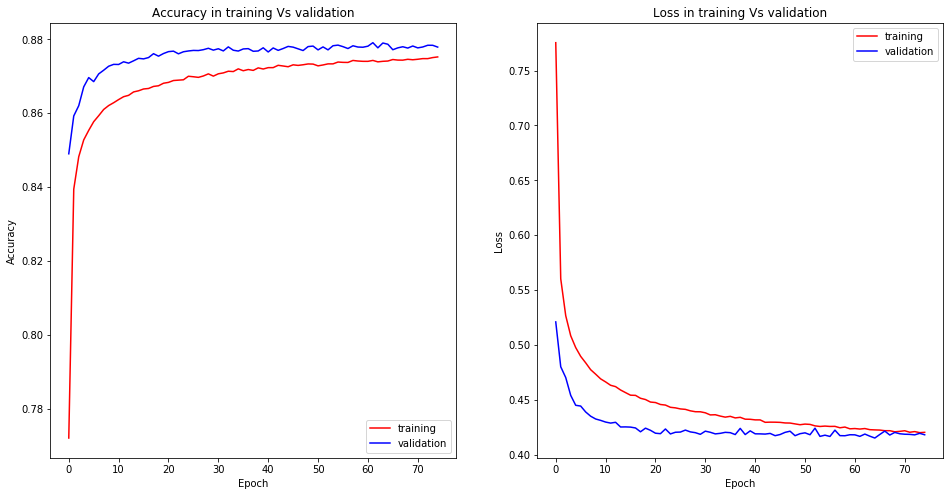

In [25]:
plot_history(history, 
             acc='acc', 
             val_acc='val_acc', 
             loss='loss', 
             val_loss='val_loss')

### Persist the model for further usage

In [26]:
base_path = "../../models/keras/products"
definition_path = f"{base_path}/ann_products_definition.yaml"
weights_path = f"{base_path}/ann_products_definition.h5"

ann_model_definition = ann_model.to_yaml()
with open(definition_path, 'w') as file:
    file.write(ann_model_definition)

ann_mode_weights = ann_model.save_weights(weights_path)

In [33]:
from keras.models import model_from_yaml
with open(definition_path, 'r') as file:
    product_class_predictor = model_from_yaml(file.read())

product_class_predictor.load_weights(weights_path)

/home/ohtar10/miniconda3/envs/wtsp/lib/python3.6/site-packages/keras/engine/saving.py:473: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(yaml_string)


In [45]:
cats = categories_encoder.classes_.tolist()

In [34]:
i = 326
instance = X_train_rs[i]
instances = np.array([instance])
prediction = product_class_predictor.predict(instances)

In [35]:
prediction.T

array([[2.7531281e-04],
       [2.3959453e-04],
       [2.9792539e-03],
       [1.0652000e-09],
       [5.9397145e-05],
       [1.1610536e-04],
       [2.7435714e-02],
       [2.5419256e-02],
       [8.0721825e-01],
       [1.3625707e-01]], dtype=float32)

In [48]:
pred = prediction.T.tolist()
list(zip(cats, pred))

[('Books', [0.00027531280647963285]),
 ('Clothing, Shoes & Jewelry', [0.00023959453392308205]),
 ('Health & Personal Care', [0.0029792538844048977]),
 ('Health, Fitness & Dieting', [1.0652000392852301e-09]),
 ('Home & Kitchen', [5.9397145378170535e-05]),
 ('Movies & TV', [0.00011610535875661299]),
 ('Music', [0.02743571437895298]),
 ('Office & School Supplies', [0.02541925571858883]),
 ('Technology, Electronics & Accessories', [0.8072182536125183]),
 ('Toys & Games', [0.13625706732273102])]

In [46]:
actual = np.array([y_train[i]])
categories_encoder.inverse_transform(actual)

[('Technology, Electronics & Accessories',)]

In [183]:
categories_encoder.classes_.tolist()

['Books',
 'Clothing, Shoes & Jewelry',
 'Health & Personal Care',
 'Health, Fitness & Dieting',
 'Home & Kitchen',
 'Movies & TV',
 'Music',
 'Office & School Supplies',
 'Technology, Electronics & Accessories',
 'Toys & Games']

In [186]:
print(documents.iloc[i].categories, documents.iloc[i].document)

Health, Fitness & Dieting;Books At a whopping 272 pages I was extremely happy with the amount of information in this book! I really like that it has the most valuable herbs and what theyre good for. There are clear instructions with measurements and steep times to make them into something like an infusion,salve, or tea, in order to use them. No filler in this book, it cuts right to the important stuff. Very helpful reference!



In [193]:
test = d2v_model.infer_vector(word_tokenize(documents.iloc[i].document))
test = np.array([test]).reshape(-1, 100, 1)
prediction = ann_model.predict(test).T
prediction

array([[9.3643916e-01],
       [2.6442685e-05],
       [5.4344703e-02],
       [7.0223724e-03],
       [6.3364205e-05],
       [5.9322734e-05],
       [1.8215749e-05],
       [1.3836478e-06],
       [1.8657617e-03],
       [1.5925262e-04]], dtype=float32)

In [194]:
pred = prediction.tolist()
pred

[[0.9364391565322876],
 [2.6442685339134187e-05],
 [0.05434470251202583],
 [0.00702237244695425],
 [6.336420483421534e-05],
 [5.932273415965028e-05],
 [1.8215749150840566e-05],
 [1.3836478274242836e-06],
 [0.001865761703811586],
 [0.00015925262414384633]]

In [175]:
[(idx, doc) for idx, doc in enumerate(documents.categories.apply(lambda cat: cat.split(";")).tolist()) if len(doc)>1]

[(326, ['Health, Fitness & Dieting', 'Books']),
 (482, ['Health, Fitness & Dieting', 'Books']),
 (565, ['Health, Fitness & Dieting', 'Books']),
 (732, ['Music', 'Movies & TV']),
 (908, ['Music', 'Movies & TV']),
 (1255, ['Health, Fitness & Dieting', 'Books']),
 (1529, ['Music', 'Movies & TV']),
 (1636, ['Music', 'Movies & TV']),
 (2053, ['Music', 'Movies & TV']),
 (2255, ['Music', 'Movies & TV']),
 (2327, ['Health, Fitness & Dieting', 'Books']),
 (2482, ['Books', 'Music']),
 (2603, ['Toys & Games', 'Clothing, Shoes & Jewelry']),
 (2610, ['Books', 'Music']),
 (2769, ['Music', 'Movies & TV']),
 (3311, ['Music', 'Movies & TV']),
 (3579, ['Health, Fitness & Dieting', 'Clothing, Shoes & Jewelry']),
 (3616, ['Health, Fitness & Dieting', 'Clothing, Shoes & Jewelry']),
 (3666, ['Music', 'Movies & TV']),
 (3786, ['Music', 'Movies & TV']),
 (4125, ['Music', 'Movies & TV']),
 (4320, ['Health, Fitness & Dieting', 'Clothing, Shoes & Jewelry']),
 (4364, ['Music', 'Movies & TV']),
 (4419, ['Health, F

## Using the models to predict new entries

In [107]:
# This is a review for https://www.amazon.com/TheFitLife-Exercise-Resistance-Bands-Handles/dp/B07KFSCD47/ref=sr_1_3?crid=K1XCSPWPYL4&dchild=1&keywords=health+and+fitness&qid=1574728656&sprefix=health+and+fits%2Caps%2C229&sr=8-3
# Which is a fitness item, lets see how well it is classified
new_entry = "music videos are such dumbass literalist bullshit now. the video to Suedehead is just Morrissey making dick poses around James Dean memorabilia. that’s the way things should be, bird brained shit the artist thinks are cool and really don’t have that much to do with the song"

In [108]:
from nltk import word_tokenize
new_entry_vector = d2v_model.infer_vector(word_tokenize(new_entry))
entries_arr = np.array([new_entry_vector]).reshape(1, 300, 1)
prediction = product_class_predictor.predict(entries_arr)
pred = prediction.T.tolist()
pred = [(cat, score[0]) for cat, score in list(zip(cats, pred))]

In [109]:
from operator import itemgetter
pred.sort(key=itemgetter(1), reverse=True)
pred

[('Music', 0.7681779861450195),
 ('Movies & TV', 0.16196848452091217),
 ('Books', 0.0637836903333664),
 ('Toys & Games', 0.004341037478297949),
 ('Health & Personal Care', 0.001013992354273796),
 ('Home & Kitchen', 0.00044169806642457843),
 ('Technology, Electronics & Accessories', 0.0001444671070203185),
 ('Clothing, Shoes & Jewelry', 8.473310299450532e-05),
 ('Office & School Supplies', 4.3405816541053355e-05),
 ('Health, Fitness & Dieting', 5.570084908868012e-07)]

It was predicted as clothing by 81%, not necessarily true, even worse, the true category fell down at the bottom